In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25) # create a array of values from -5 to 5 in steps of .25 not including 5
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

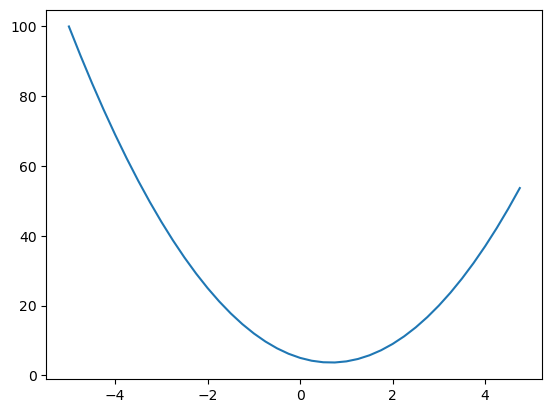

In [6]:
plt.plot(xs, ys)

In [7]:
h=0.00000001
x=2/3
slope = (f(x+h) - f(x))/h
slope

0.0

In [8]:
#complex example
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [9]:
h=0.00000001

a=2.0
b=-3.0
c=10.0

d1=a*b+c
c+=h
d2=a*b+c

print("d1 =", d1)
print("d2 =", d2)
print("slope =", (d2-d1)/h)



d1 = 4.0
d2 = 4.000000010000001
slope = 1.000000082740371


In [10]:
class Value:
    
    def __init__(self, data, _children=(), _opr='', _label=''): 
        self.data = data
        self._prev = set(_children) #storing the values which were used as inputs
        self._opr = _opr 
        self._label = _label
        self._grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self._grad += 1.0 * out._grad  # remember the case of a + a -> 1 + 1 will be 2, 
            other._grad += 1.0 * out._grad # but we would override it to 1 if don't use '+='
            
        out._backward = _backward   
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other ** - 1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) #only supporting int/fload powers for now
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self._grad = (other * self.data ** (other - 1)) * out._grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self._grad += other.data * out._grad
            other._grad += self.data * out._grad
            
        out._backward = _backward          
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self._grad += out.data * out._grad #out.data -> local derivative, then * out._grad for chain rule of derivative
        out._backward = _backward
        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self._grad = (1 - t**2) * out._grad
            
        out._backward = _backward        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self) #start building topo sort with self

        self._grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
a=Value(2.0, _label = 'a')
b=Value(4, _label = 'b')
a.exp()
a/b

Value(data=0.5)

In [12]:
a - b

Value(data=-2.0)

In [13]:
2 * a

Value(data=4.0)

In [14]:
c = a*b # --> a.__add__(b)
c._label = 'c'
c

Value(data=8.0)

In [15]:
d = a+b
d._label = 'd'
d

Value(data=6.0)

In [16]:
d._prev

{Value(data=2.0), Value(data=4)}

In [17]:
d._opr

'+'

In [18]:
d= Value(-6.0)
d._label = 'd'
e = c+d
e._label = 'e'
f= Value(-2.0)
f._label = 'f'
L = f*e
L._label = 'L'

In [15]:
!pip install graphviz

In [19]:
from graphviz import Digraph

def trace(root):
    #builds a set of all mode and edges on a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR -> Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a ractangular ('record') node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n._label, n.data, n._grad), shape='record')
        if n._opr:
            #if this value is a result of some opr, create an OP node
            dot.node(name = uid + n._opr, label = n._opr)
            #and connet this node to it
            dot.edge(uid + n._opr, uid)
            
    for n1, n2 in edges:
        #connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._opr)
        
    return dot

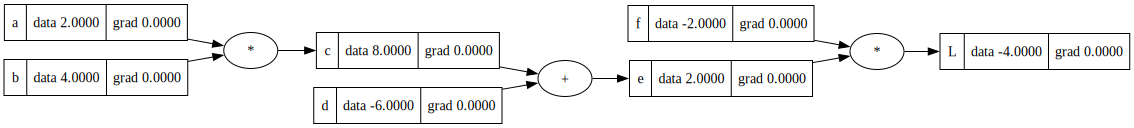

In [20]:
draw_dot(L)

In [21]:
#inputs x1 & x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

#weights w1 & w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

#bias of the neuron
b = Value(6.8813735870195432, _label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1._label='x1w1'
x2w2 = x2*w2; x2w2._label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label='x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label='o'

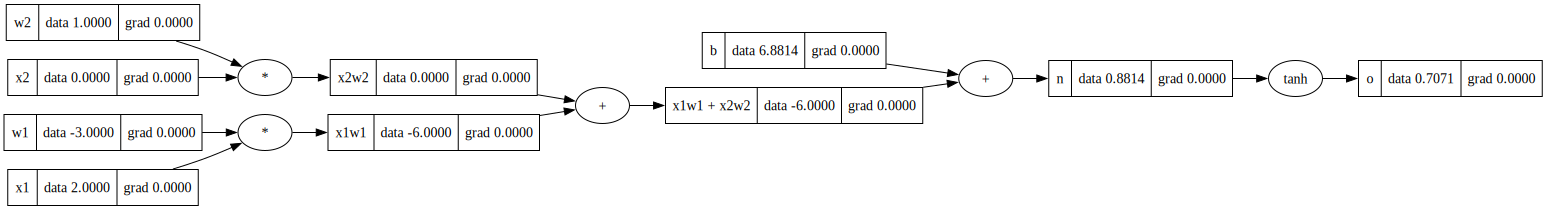

In [22]:
draw_dot(o)

In [28]:
#o._grad = 1.0
#o._backward()

In [29]:
# o = tanh(n)
#do/dn = 1 - tanh(n)**2 = 1 - o**2
#n._grad = 1 - o.data**2
#n._backward()
#b._backward()

In [30]:
#x1w1x2w2._backward()

In [31]:
#x1w1._backward()
#x2w2._backward()

In [35]:
#following code moved to the value class
'''
o._grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()
'''

In [36]:
#topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [23]:
o.backward() #calling the function in value class -> notice the name: not _backward

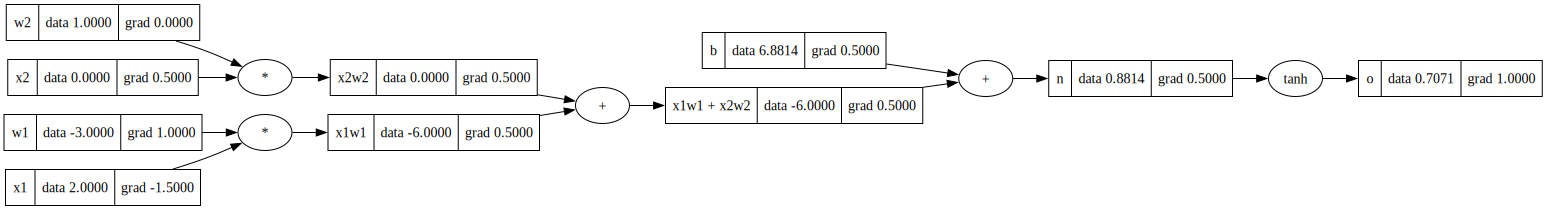

In [24]:
draw_dot(o)

In [25]:
#inputs x1 & x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

#weights w1 & w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

#bias of the neuron
b = Value(6.8813735870195432, _label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1._label='x1w1'
x2w2 = x2*w2; x2w2._label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label='x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

In [26]:
e = (2*n).exp()
o = (e - 1)/(e + 1)

In [27]:
o._label = 'o'
e._label = 'e'

In [28]:
o.backward()

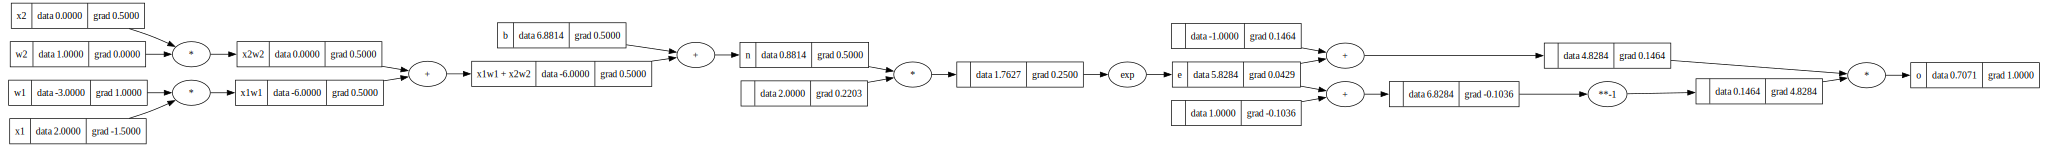

In [29]:
draw_dot(o)

In [30]:
import torch

In [31]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
    
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
    
n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [32]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [98]:
import random

class Neuron:
    def __init__(self, nin): # takes the number of inputs to the neuron
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)] # gives weights b/w -1 and 1 to all inputs 
        self.b=Value(random.uniform(-1,1)) # assigns a bias 
        
    def __call__(self, x):
        # w*x + b
        #act = sum((wi * xi for wi, xi in zip(self.w, x)), Value(0.0)) + self.b 
        #print(list(zip(self.w, x)))                       # 0 + (wi * xi) -> use Value(0.0)
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out # for now return 0.0
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # for convinience return outs[0] when its a single value in list, else return the list
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''
        params = []
        for neuron in self.neurons:
            param = neuron.parameters
            params.extend(param)
        return params
        '''
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        '''
        for MLP(nin = 3, nouts=[4,2,1])
        
        input layer has 3 inputs
        1st hidden layer has 4 neurons, 2nd has 2 and final layer has 1 (output) neuron
        
        sz = [nin] + nouts = [3, 4, 2, 1]
        
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        this builds: Layer(3, 4), Layer(4, 2) and Layer(2, 1) 
        each layer of (a, b) consists of 'b' neurons and each expecting 'a' inputs
        '''
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        '''
        mlp = MLP(3, [4, 2, 1])
        output = mlp([1.0, 2.0, 3.0])

        Iternation 1: Layer (3, 4)
        layer has 4 neurons, each expecting 3 inputs
        3 inputs are [1.0, 2.0, 3.0]
        each neuron then computes
        output = tanh(w1*x1 + w2*x2 + w3*x3 + b)
        4 outputs (1 per neuron) are [a1, a2, a3, a4] -> inputs for next layer

        Iternation 2: Layer(4, 2): 2 neurons each with 4 inputs (a1, a2, a3, a4)
        each of 2 neuron computs
        output = tanh(w1*a1 + w2*a2 + w3*a3 + w4*a4 + b)
        and let's say put [b1, b2]

        Iternation 3: Layer(2, 1): 1 neuron and 2 inputs (b1, b2)
        output = tanh(w1*b1 + w2*b2 + b)
        final output
        '''
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        '''
        params = []
        for layer in self.layers:
            param = layer.parameters
            params.extend(param)
        return params
        '''
    

In [233]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8456259789422916)

In [169]:
n.parameters()

[Value(data=-0.9732322163179856),
 Value(data=-0.6599139507675778),
 Value(data=0.397741338294187),
 Value(data=0.2073818519288202),
 Value(data=-0.006435466840850168),
 Value(data=-0.8220694514408402),
 Value(data=0.6590047368408627),
 Value(data=-0.6901080993089785),
 Value(data=0.469018861417974),
 Value(data=-0.9636171578354868),
 Value(data=-0.8983668530811177),
 Value(data=-0.3657548639100323),
 Value(data=0.3279383547532766),
 Value(data=-0.7964836242014439),
 Value(data=0.4876500473930949),
 Value(data=-0.30796804850040194),
 Value(data=0.7701736687767069),
 Value(data=-0.1869620459742336),
 Value(data=-0.28814539179580234),
 Value(data=0.21319724839561038),
 Value(data=-0.996046883742342),
 Value(data=0.968030971177043),
 Value(data=0.2220562313178902),
 Value(data=-0.04896408954631659),
 Value(data=0.5880595072211274),
 Value(data=0.5881269570441858),
 Value(data=0.7876103410856945),
 Value(data=-0.8434323202901708),
 Value(data=0.4192966650272194),
 Value(data=0.203516711934

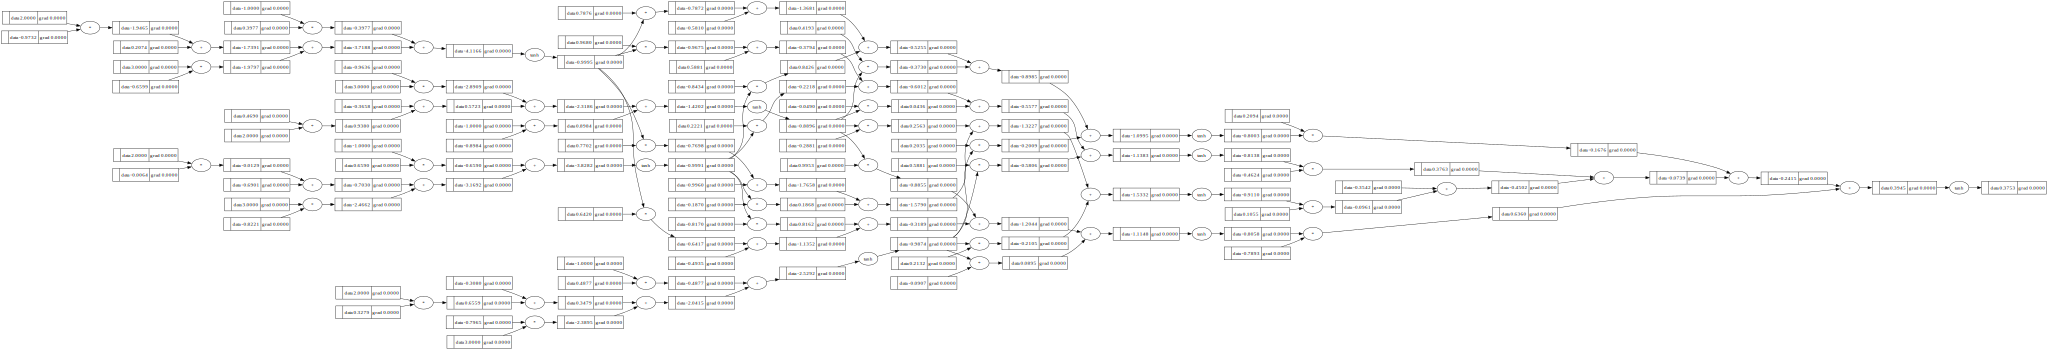

In [170]:
draw_dot(n(x))

In [245]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3264055818248195)

In [246]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1,0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

#ypred = [n(x) for x in xs]
#ypred

In [172]:
#loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
#loss

Value(data=3.3937923681942515)

In [173]:
#loss.backward()

In [174]:
#n.layers[0].neurons[0].w[0]._grad

-0.5435255041901697

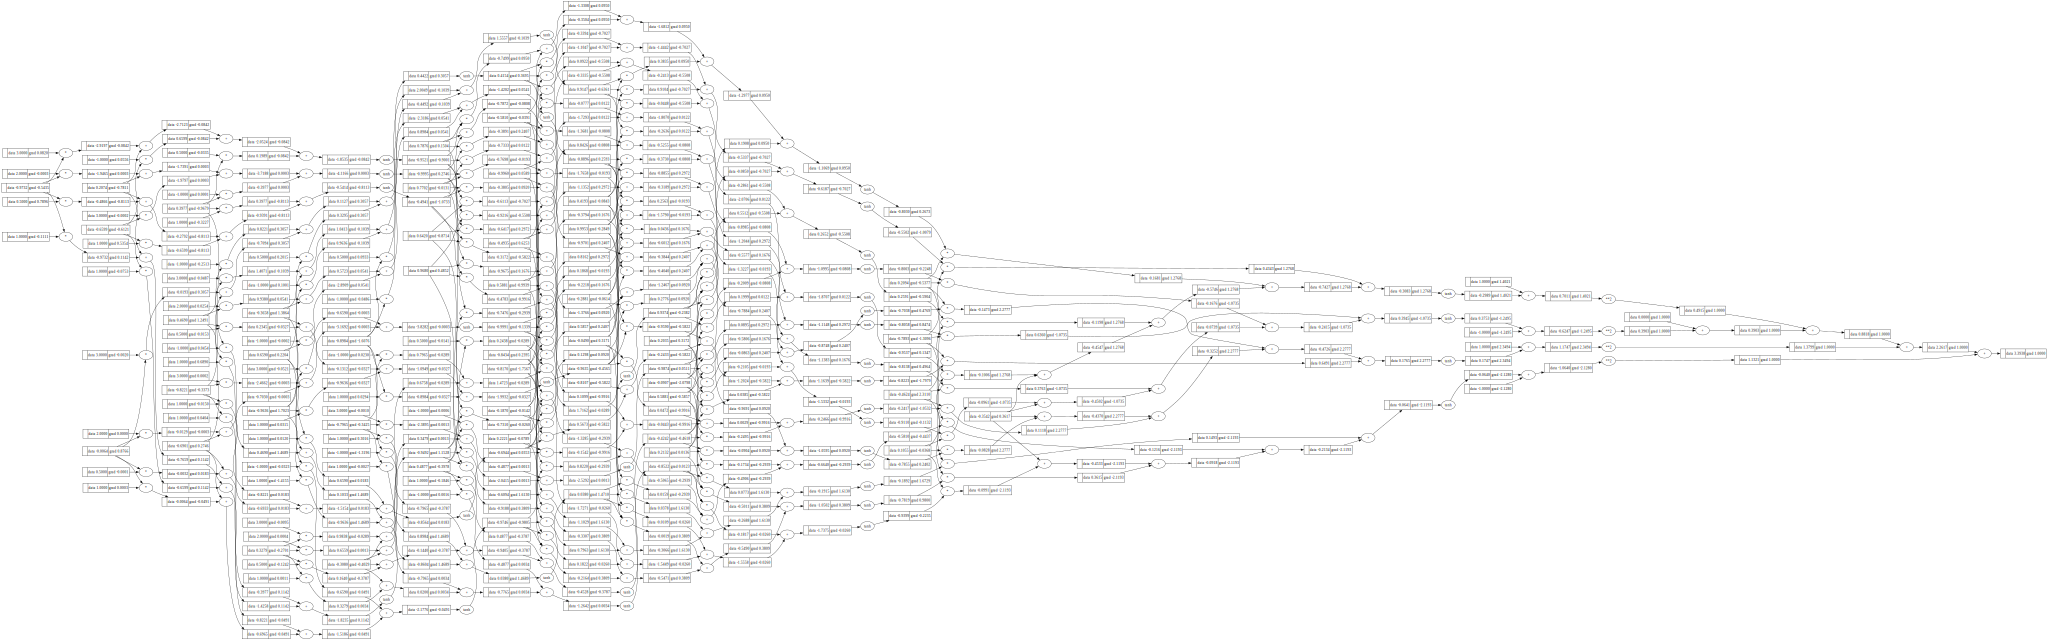

In [175]:
draw_dot(loss)

In [176]:
#n.layers[0].neurons[0].w[0].data

-0.9732322163179856

In [228]:
#for p in n.parameters():
#    p.data += -0.01 * p._grad

In [229]:
#ypred = [n(x) for x in xs]
#loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
#loss

Value(data=8.722378130501937e-05)

In [230]:
#loss.backward()

In [124]:
#n.layers[0].neurons[0].w[0]._grad

-0.4457118461382766

In [125]:
#n.layers[0].neurons[0].w[0].data

0.24960756007342716

In [231]:
#ypred

[Value(data=0.9970730986739197),
 Value(data=-0.9979603050838527),
 Value(data=-0.9948970336416196),
 Value(data=0.9930389362216189)]

In [232]:
#n.parameters()

[Value(data=-0.4663760473805816),
 Value(data=-0.06433628798305349),
 Value(data=1.264500321832563),
 Value(data=0.94724877935657),
 Value(data=-0.2670527375345905),
 Value(data=-0.6044812199756734),
 Value(data=0.7008551957672288),
 Value(data=-0.6857117796584826),
 Value(data=0.2199554804720331),
 Value(data=-1.4810890718112486),
 Value(data=-0.419426925685421),
 Value(data=-0.7244164200783263),
 Value(data=0.5383771756397205),
 Value(data=-0.4144859084754822),
 Value(data=1.111079881283895),
 Value(data=0.12980066590847947),
 Value(data=0.7639766145798951),
 Value(data=-0.16604930788775413),
 Value(data=-0.2381474745413299),
 Value(data=0.20087545016516775),
 Value(data=-1.0465120148947755),
 Value(data=1.180698394563048),
 Value(data=0.37895556403268504),
 Value(data=-0.16695886169727459),
 Value(data=1.296135361298585),
 Value(data=1.0720817975646864),
 Value(data=0.63186686782706),
 Value(data=-0.9402064711400423),
 Value(data=0.4754625994947024),
 Value(data=-0.03357989708126299

In [257]:
for k in range(1000):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
    
    #backward pass
    for p in n.parameters():
        p._grad = 0.0 # set the grad to zero as we should not keep on adding the grad when we do the backward pass, rather we need to find the new grad value
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p._grad
        
    #print(k, loss)
        

In [258]:
ypred

[Value(data=0.9903043925036364),
 Value(data=-0.9920469112667102),
 Value(data=-0.988274510852376),
 Value(data=0.9881079923264785)]